In [3]:
from sklearn.datasets import load_iris
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve, precision_recall_curve, average_precision_score
sns.set_palette('Spectral')

/home/mustafa/miniconda3/envs/t2/lib/python3.13/site-packages/numpy/_core/getlimits.py:551: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [4]:
data = load_iris(as_frame=True)
features = data.data
target  = data.target

print(features.head())
print('\n')
print(target.head())

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2


0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64


In [5]:
features = features.rename(columns={'sepal length (cm)': 'sepal length', 'sepal width (cm)': 'sepal width', 'petal length (cm)': 'petal length', 'petal width (cm)': 'petal width'})
features.head()

,sepal length,sepal width,petal length,petal width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [6]:
print(features.shape)

(150, 4)


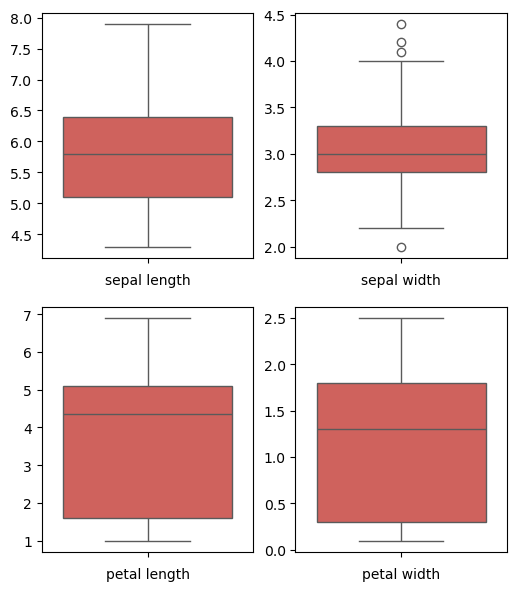

In [7]:
figure, axes = plt.subplots(nrows=2, ncols=2, figsize=(6, 7))
axes = axes.flatten()

for index, column in enumerate(features.columns):
    sns.boxplot(features[column], ax=axes[index])
    axes[index].set_ylabel(None)
    axes[index].set_xlabel(column)

In [8]:
target.value_counts()

target
0    50
1    50
2    50
Name: count, dtype: int64

In [9]:
class CustomLogisticRegression:
    def __init__(self, learning_rate=0.01, number_of_epochs=1000,
                 regularization_strength=0.01, regularize=False, scale=False,
                 verbose=False, log_every=100,
                 ):
        self.weights_vector = None                  # weights of features (coefficients). shape(n_features,)
        self.bias = None                            # bias (intercept)
        self.learning_rate = learning_rate          # learning rate
        self.number_of_epochs = number_of_epochs    # number of training epochs
        self.final_loss = None                      # last loss value of the model
        self.loss_history = []                      # all losses generated by the model
        self.regularize = regularize                # should the model add regularization
        self.regularization_strength = regularization_strength  # should the model regularize, how strong the regularization be
        self.scale = scale                          # should the model scale the data before fitting
        self.scaler = None                          # the scaler used to scale the model
        self.verbose = verbose
        self.log_every = log_every

    def _sigmoid(self, z):
        # Activation function to turn the output of the forward propogation (raw values - z) to a probability
        z = np.clip(z, -500, 500)  # Clipping to avoid overflow
        return 1 / (1 + np.exp(-z))
    
    def _log_loss(self, y, y_hat):
        # the cost function of a logistic regression
        epsilon = 1e-10
        mean_loss = -np.mean(y * np.log(y_hat + epsilon) + (1 - y) * np.log(1 - y_hat + epsilon))
        if self.regularize:
            l2_penalty = (self.regularization_strength / 2) * np.sum(self.weights_vector ** 2)
            return mean_loss + l2_penalty
        else:
            return mean_loss
    
    def _forward_propogation(self, X, y):
        z = X @ self.weights_vector + self.bias  # (n_samples x n_features) @ (n_features,) --> shape(n_samples,)
        y_hat = self._sigmoid(z)  # outputs probability for each row(sample) in X
        loss = self._log_loss(y, y_hat)
        self.loss_history.append(loss)
        return y_hat, loss

    def _back_propogation(self, X, y, y_hat):
        difference_between_predictions_and_actual_values = y_hat - y  # shape(n_samples,)
        bias_derivative = np.mean(difference_between_predictions_and_actual_values)  # bias not affected by regularization
        
        number_of_samples = X.shape[0]
        if self.regularize:
            weights_derivative = ( X.T @ difference_between_predictions_and_actual_values ) / number_of_samples + ( self.regularization_strength * self.weights_vector )  # shape(n_features,)
        else:
            weights_derivative = X.T @ (difference_between_predictions_and_actual_values) / number_of_samples
        return weights_derivative, bias_derivative 

    def _update(self, weights_derivative, bias_derivative):
        self.weights_vector = self.weights_vector - self.learning_rate * weights_derivative
        self.bias = self.bias - self.learning_rate * bias_derivative
        
    def fit(self, X, y):
        if self.scale:  # assumes the split happended before calling fit
            self.scaler = StandardScaler() 
            X = self.scaler.fit_transform(X)

        self.weights_vector = np.zeros(X.shape[1])  # shape(n_features,) because there's only one output per sample. If multiclass, then shape(n_features, k) where k is the number of classes
        self.bias = 0  # single value because there's only one output per sample. If multiclass, then shape(k, ), where k is the number of classes
        for epoch in range(self.number_of_epochs):
            y_hat, loss = self._forward_propogation(X, y)
            weights_derivative, bias_derivative = self._back_propogation(X, y, y_hat)
            self._update(weights_derivative, bias_derivative)

            if self.verbose and (epoch % self.log_every == 0 or epoch == self.number_of_epochs - 1):
                # print(f'Epoch: {epoch} | Loss: {loss} | Weights Norm: {np.linalg.norm(self.weights_vector):.2f}')
                print(f"Epoch {epoch:<5} | Loss: {loss:.5f} | Weights Norm: {np.linalg.norm(self.weights_vector):.5f}")

        self.final_loss = loss
        return self
    
    def predict_probability(self, X):
        if self.scale and self.scaler is not None:
            X = self.scaler.transform(X)
        z = X @ self.weights_vector + self.bias
        return self._sigmoid(z)

    def predict(self, X):
        if self.scale and self.scaler is not None:
            X = self.scaler.transform(X)
        probabilites = self.predict_probability(X)
        return (probabilites >= 0.5).astype(int)

    def inverse_transform(self):
        if self.scale == False or self.scaler is None:
            raise ValueError('Data was not scaled, so it cannot be inverse transformed')
        standard_deviations = self.scaler.scale_
        original_weights = self.weights_vector / standard_deviations
        means = self.scaler.mean_
        original_intercept = self.bias - np.sum(self.weights_vector * means / standard_deviations)
        return original_weights, original_intercept

    def plot_losses(self):
        '''
            Plot losses over the epochs as the model is training
        '''
        plt.plot(self.loss_history, label=f'Final loss: {self.final_loss:.2f}')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training Loss Over Epochs')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_precision_recall_curve(self, y_test, prediction_probabilities):
        '''
            The Precision-Recall Curve is a tool to evaluate a classifier—especially useful
            for imbalanced datasets where positive and negative classes are not evenly distributed.
        '''
        precision, recall, _ = precision_recall_curve(y_test, prediction_probabilities)
        plt.plot(recall, precision)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.grid(True)
        plt.show()
    
    def plot_roc_area_curve(self, true_values, prediction_probabilities):
        '''
            Plot the ROC (Receiver Operating Characteristic) area curve.
        '''
        false_positive_rate, true_positive_rate, _ = roc_curve(true_values, prediction_probabilities)
        auc_value = auc(false_positive_rate, true_positive_rate)
        plt.plot(false_positive_rate, true_positive_rate, label=f'Model (AUC = {auc_value:.2f})')
        plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')
        plt.xlabel('False Positive Rates')
        plt.ylabel('True Positive Rates')
        plt.title('ROC area curve')
        plt.legend()
        plt.grid(True)
        plt.show()

In [10]:
'''
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, shuffle=True, random_state=100)
print(X_train.shape)
print(X_test.shape)

lr = CustomLogisticRegression(learning_rate=0.00005, number_of_epochs=1000, verbose=True, log_every=100).fit(X_train, y_train)
predictions = lr.predict(X_test)

lr.plot_losses()

print(f'Final weights:\n{lr.weights_vector}')
print(f'Final bias: {lr.bias}')

print(f'Accuracy: {accuracy_score(y_test, predictions):.2f}')
# print(f'F1 Score: {f1_score(y_test, predictions):.2f}')
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, cmap='Blues', cbar=False
            , xticklabels=data.target_names, yticklabels=data.target_names)
'''

"\nX_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, shuffle=True, random_state=100)\nprint(X_train.shape)\nprint(X_test.shape)\n\nlr = CustomLogisticRegression(learning_rate=0.00005, number_of_epochs=1000, verbose=True, log_every=100).fit(X_train, y_train)\npredictions = lr.predict(X_test)\n\nlr.plot_losses()\n\nprint(f'Final weights:\n{lr.weights_vector}')\nprint(f'Final bias: {lr.bias}')\n\nprint(f'Accuracy: {accuracy_score(y_test, predictions):.2f}')\n# print(f'F1 Score: {f1_score(y_test, predictions):.2f}')\nsns.heatmap(confusion_matrix(y_test, predictions), annot=True, cmap='Blues', cbar=False\n            , xticklabels=data.target_names, yticklabels=data.target_names)\n"

In [11]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, shuffle=True, random_state=100)
print(X_train.shape)
print(X_test.shape)

(105, 4)
(45, 4)


In [12]:
lr_sklearn = LogisticRegression().fit(X_train, y_train)
predictions_sklearn = lr_sklearn.predict(X_test)
prediction_probabilities_sklearn = lr_sklearn.predict_proba(X_test)

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr_sklearn_scaled = LogisticRegression().fit(X_train_scaled, y_train)
predictions_sklearn_scaled = lr_sklearn_scaled.predict(X_test_scaled)
prediction_probabilities_sklearn_scaled = lr_sklearn.predict_proba(X_test_scaled)

/home/mustafa/miniconda3/envs/t2/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [14]:
from sklearn.metrics import recall_score, precision_score

accuracy_before_scaling = accuracy_score(y_test, predictions_sklearn)
accuracy_after_scaling = accuracy_score(y_test, predictions_sklearn_scaled)

recall_before_scaling = recall_score(y_test, predictions_sklearn, average='macro')
recall_after_scaling = recall_score(y_test, predictions_sklearn_scaled, average='macro')

precision_before_scaling = precision_score(y_test, predictions_sklearn, average='macro')
precision_after_scaling = precision_score(y_test, predictions_sklearn_scaled, average='macro')

f1_before_scaling = f1_score(y_test, predictions_sklearn, average='macro')
f1_after_scaling = f1_score(y_test, predictions_sklearn_scaled, average='macro')

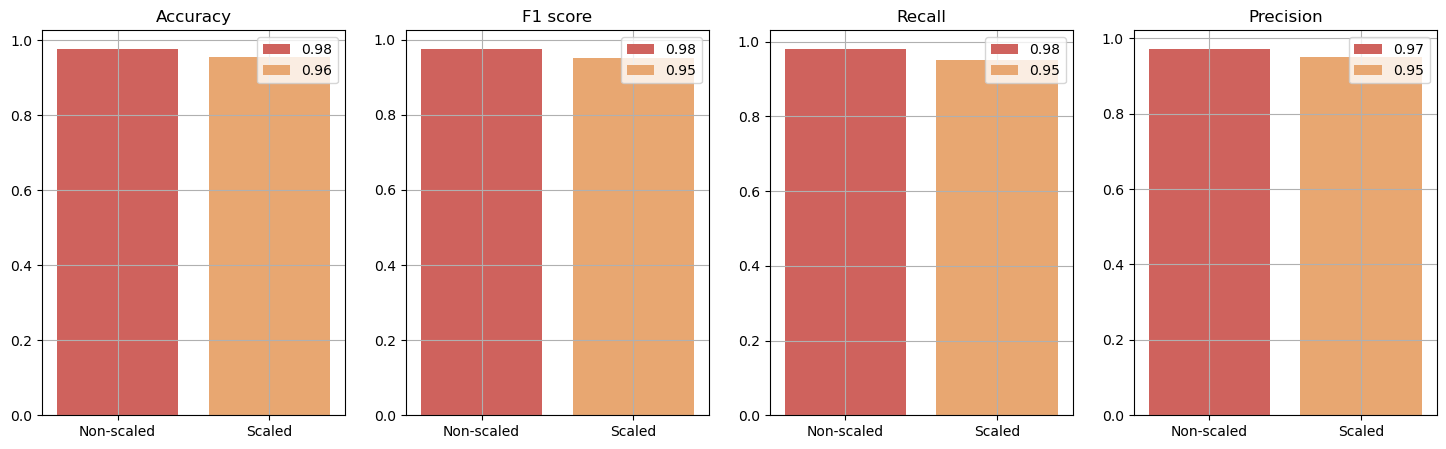

In [15]:
fig, ax = plt.subplots(1, 4, figsize=(18, 5))
sns.barplot(x=['Non-scaled'], y=accuracy_before_scaling, label=f'{accuracy_before_scaling:.2f}', ax=ax[0])
sns.barplot(x=['Scaled'], y=accuracy_after_scaling, label=f'{accuracy_after_scaling:.2f}',ax=ax[0])

sns.barplot(x=['Non-scaled'], y=f1_before_scaling, label=f'{f1_before_scaling:.2f}', ax=ax[1])
sns.barplot(x=['Scaled'], y=f1_after_scaling, label=f'{f1_after_scaling:.2f}',ax=ax[1])

sns.barplot(x=['Non-scaled'], y=recall_before_scaling, label=f'{recall_before_scaling:.2f}', ax=ax[2])
sns.barplot(x=['Scaled'], y=recall_after_scaling, label=f'{recall_after_scaling:.2f}',ax=ax[2])

sns.barplot(x=['Non-scaled'], y=precision_before_scaling, label=f'{precision_before_scaling:.2f}', ax=ax[3])
sns.barplot(x=['Scaled'], y=precision_after_scaling, label=f'{precision_after_scaling:.2f}',ax=ax[3])

ax[0].grid(True); ax[0].set_title('Accuracy')
ax[1].grid(True); ax[1].set_title('F1 score')
ax[2].grid(True); ax[2].set_title('Recall')
ax[3].grid(True); ax[3].set_title('Precision');

Text(0.5, 1.0, 'After scaling')

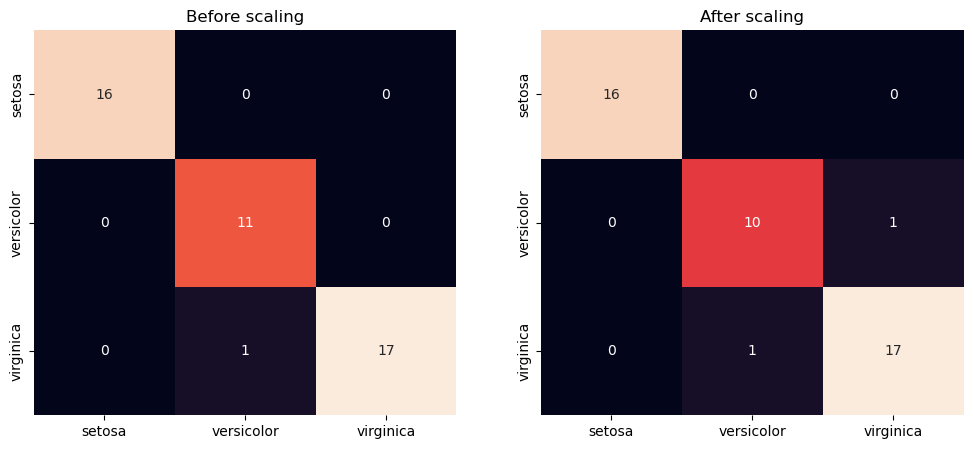

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(confusion_matrix(y_test, predictions_sklearn), annot=True, cbar=False
            , xticklabels=data.target_names, yticklabels=data.target_names, ax=ax[0])
sns.heatmap(confusion_matrix(y_test, predictions_sklearn_scaled), annot=True,cbar=False
            , xticklabels=data.target_names, yticklabels=data.target_names, ax=ax[1])
ax[0].set_title('Before scaling')
ax[1].set_title('After scaling')

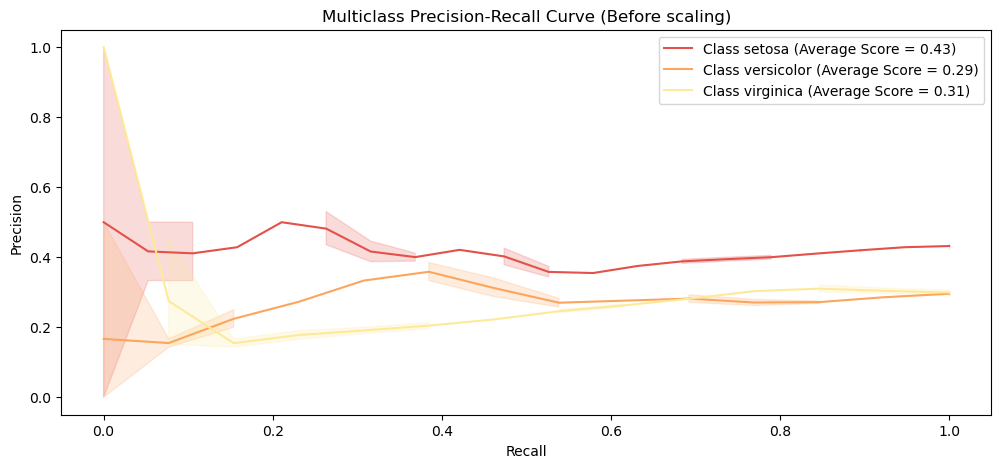

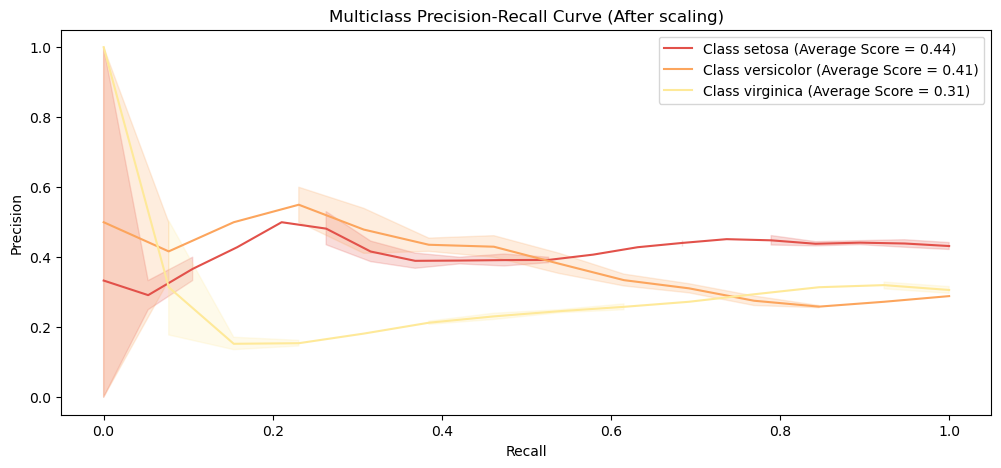

In [17]:
y_bin = label_binarize(target, classes=[0, 1, 2])
n_classes = y_bin.shape[1]
X_train, X_test, y_train_bin, y_test_bin = train_test_split(features, y_bin, test_size=0.3, random_state=42)

plt.figure(figsize=(12, 5))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], prediction_probabilities_sklearn[:, i])
    average_score = average_precision_score(y_test_bin[:, i], prediction_probabilities_sklearn[:, i])
    sns.lineplot(x=recall, y=precision, label=f'Class {data.target_names[i]} (Average Score = {average_score:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Multiclass Precision-Recall Curve (Before scaling)')

plt.figure(figsize=(12, 5))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], prediction_probabilities_sklearn_scaled[:, i])
    average_score = average_precision_score(y_test_bin[:, i], prediction_probabilities_sklearn_scaled[:, i])
    sns.lineplot(x=recall, y=precision, label=f'Class {data.target_names[i]} (Average Score = {average_score:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Multiclass Precision-Recall Curve (After scaling)');